In [1]:
# code to generate yearly summaries of DUNE data volumes from input parameters
# rewritten from the version in the CDR - mainly by using maps of years instead of arrays to make it clearer what is in each year.
# HMS 2022-10-23


import os,sys,string,time,commentjson,datetime, math
from csv import reader
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

DEBUG = False
DRAW = True
import numpy as np

from NumberUtils import dump
from NumberUtils import DrawTex
from NumberUtils import cumulateMap
from NumberUtils import DrawDet
from NumberUtils import DrawType
from NumberUtils import makeArray
from NumberUtils import ToCSV1
from NumberUtils import ToCSV2
from NumberUtils import SumOver1
from NumberUtils import SumOver2
from NumberUtils import TableTex
from NumberUtils import DrawTex
from NumberUtils import BothTex

In [2]:
"Tex"# read in a configfile
configfilename = "Parameters_2022-11-21-2040.json"

#if len(sys.argv) > 1:
#  configfile = sys.argv[1]

shortname = configfilename.replace(".json","")
if os.path.exists(configfilename):
  with open(configfilename,'r') as f:
    config = commentjson.load(f)
else:
  print ("no config file",configfilename)
  sys.exit(0)

if not "Version" in config or config["Version"] < 5:
  print (" this code expects Version >= 2")
  sys.exit(1)

json_formatted_str = commentjson.dumps(config, indent=2)

In [3]:
MaxYear = config["MaxYear"]
config["filename"] = configfilename.replace("_","\_")
MinYear = config["MinYear"]
Detectors = config["Detectors"]
if DEBUG:
  Detectors = ["SP","SP2","DP"]
Years = np.array(config["Years"])
#if DEBUG:
#  Years = Years[0:7]


shortname = shortname.replace("2040","%d"%MaxYear)
dirname = shortname
if not os.path.exists(dirname):
    os.mkdir(dirname)
shortname = dirname+"/"+dirname
# make a tex output file
texfilename = dirname+".tex"
texfile = open(texfilename,'w')
tablefile = open(os.path.join(dirname,"tables.tex"),'w')
#texfile.write("\\input{Header.tex}\n")

- Read in the config file

In [4]:



size = len(Years)

Units = config["Units"]
Formats = config["Formats"]

Detectors = config["Detectors"]

Cap = config["Cap"]

BaseMemory = config["Base-Memory"]

print (Detectors)

CombinedDetectors = config["CombinedDetectors"]

DetectorParameters = list(config["SP"].keys())

if "Comment" in DetectorParameters:
    DetectorParameters.remove("Comment")

TapeLifetimes = config["TapeLifetimes"]

DiskLifetimes = config["DiskLifetimes"]

TapeCopies = config["TapeCopies"]

DiskCopies = config["DiskCopies"]

# this is how far you go back each time you reprocess reco.
Reprocess = config["Reprocess"]

PerYear = config["PerYear"]

StorageTypes = list(TapeCopies.keys())

# plot config
DetColors=config["DetColors"]
DetLines = config["DetLines"]
TypeColors=config["TypeColors"]
TypeLines = config["TypeLines"]

PatternFraction = config["PatternFraction"]

SplitsYear = config["SplitsYear"]
SplitsEarly = config["SplitsEarly"]
SplitsLater = config["SplitsLater"]

Explain = config["Explain"]
Explain["filename"] = "Input configuration file"

diskactual = config["Actual"]["diskactual"]
tapeactual = config["Actual"]["tapeactual"]
wallactual = config["Actual"]["wallactual"]

['SP', 'SP2', 'DP', 'PDVD', 'HD', 'VD', 'ND']


In [5]:
for f in Explain.keys():
    
    tablefile.write("{\\tt %s:} %s = {\\tt %s} \\\\\n"%(f,Explain[f], config[f]))
    print (Explain[f])

Detectors included in the calculation
Cap on Raw data/year in PB
MB of memory per slot assumed as the average
Plot until year
Plot starting with year
Number of years of data reprocessed when doing a new pass
Fraction of time taken in pattern recognition
Number of years kept on tape
Number of years kept on disk
Number of copies kept on tape
Number of copies kept on disk
Number of reprocessing done per year
Description of cores, efficiency and speed relative to 2020 vintage
kHEPSPEC06 per core assumed
Year CERN no longer responsible for disk or tape
Division between FNAL/CERN/National for storage until SplitsYear
Division between FNAL/CERN/National for storage after SplitsYear
Input configuration file


- Use the inputs to add some new yearly like CPU and disk sizes 

In [6]:
dofirst = ["Events","Test","Sim-Events"]
print ("Detector Parameters",DetectorParameters)
# read in the raw information

Inputs = {}
for det in Detectors:
  Inputs[det]={}
  for type in dofirst:
      Inputs[det][type]={}
      for year in Years:
          Inputs[det][type][year] = float(config[det][type][year-Years[0]])

# fill in other useful arrays
for det in Detectors:
  if DEBUG: print ("Events",det,Inputs[det]["Events"])
  #print ("see it", det,Inputs[det].keys())
  for key in DetectorParameters:
    #print(key,det)
    # skip the ones already done
    if key in dofirst:
      continue
    
    # sim has its own configuration
    # print ("this is the key",det,key)
    
    if key in ["Reco-Data-CPU","Reco-Data-Store"]:  # if doing reco, do over previous events using memory
        Inputs[det][key] = cumulateMap(Years,Inputs[det]["Events"],Reprocess[det])
        for year in Years:
            Inputs[det][key][year] *= config[det][key]
        if key == "Reco-Data-CPU":
            print ("fix the memory",config[det]["Reco-Memory"]/BaseMemory)
            for year in Years:
                Inputs[det][key][year] *= (config[det]["Reco-Memory"]/BaseMemory)
        continue
        
    if key == "Raw-Store":
        Inputs[det][key] ={}
        for year in Years:
            Inputs[det][key][year] = Inputs[det]["Events"][year]*config[det][key]
        continue
        
    if key in ["Sim-Store","Sim-CPU"]:
        
        Inputs[det][key] ={}
        for year in Years:
            Inputs[det][key][year]=Inputs[det]["Sim-Events"][year]*config[det][key]
            if key == "Sim-CPU":
                Inputs[det][key][year]*=(config[det]["Sim-Memory"]/BaseMemory)
        continue
    if DEBUG: print ("other key",det,key)


# do a little cleanup

for det in Inputs.keys():
    
    if "Sim-Memory" in Inputs[det]:
        Inputs[det].pop("Sim-Memory")
    if "Reco-Memory" in Inputs[det]:
        Inputs[det].pop("Reco-Memory")

Detector Parameters ['Raw-Store', 'Reco-Data-CPU', 'Sim-CPU', 'Reco-Data-Store', 'Sim-Store', 'Reco-Memory', 'Sim-Memory', 'Events', 'Test', 'Sim-Events']
fix the memory 2.0
fix the memory 2.0
fix the memory 2.0
fix the memory 2.0
fix the memory 2.0
fix the memory 2.0
fix the memory 1.0


In [7]:
# make a data file which uses # of events to figure out how big samples are

if PerYear["Reco-Data-Store"]!=PerYear["Reco-Data-CPU"]:
    print ("Data growth has to match reprocessing cycles/year")
    PerYear["Reco-Data-Store"] = PerYear["Reco-Data-CPU"]
if PerYear["Sim-Store"]!=PerYear["Sim-CPU"]:
    print ("Sim growth has to match reprocessing cycles/year")
    PerYear["Sim-Store"] = PerYear["Sim-CPU"]

Data = {}
dump = open("dump.txt",'w')

    
#print (Inputs.keys())
fields = list(Inputs["ND"].keys())
#print ("fields",fields)
for dtype in fields:
  Data[dtype] = {}
  if "Memory" in dtype:
        continue
  for det in Inputs.keys():
    Data[dtype][det] = {}
    # this allows you to, say, do 2 passes of reco/year
    for year in Years:
        Data[dtype][det][year] = Inputs[det][dtype][year] * float(PerYear[dtype])
    # compensate for nominal units being millions and TB or singles and MB
    if Units[dtype] == "PB":
        for year in Years:
            Data[dtype][det][year] *= 0.001
    ds = "data %s %s %f\n"%(dtype,det,Data[dtype][det][2022])
    dump.write(ds)

- impose a cap at Cap (30 PB/year if set)

In [8]:
# impose a cap at Cap on things derived from raw data

dtype = "Raw-Store"

Data["Raw-Store"]["Total"] = {}
for year in Years:
        Data[dtype]["Total"][year] = 0.0
for det in Inputs.keys():
    for year in Years:
        Data[dtype]["Total"][year] +=  Data["Raw-Store"][det][year]
        
dtypes = ["Raw-Store","Reco-Data-CPU"]
for dtype in dtypes:
    for det in Inputs.keys():
        #print (dtype,det,2035,1.0,Data[dtype][det][2035] )
        for year in Years:
            cap = Data["Raw-Store"]["Total"][year]/Cap
           # print (dtype,det,year,cap,Data[dtype][det][year] )
            if cap > 1:
                Data[dtype][det][year] /=cap
        #print (dtype,det,2035,cap,Data[dtype][det][2035] )

- try to estimate analysis size - this could be improved as right now it just rescales from sim+reco

In [9]:
# build analysis

Data["Analysis-CPU"]= {}

for det in Inputs.keys():
    Data["Analysis-CPU"][det] = {}
    for year in Years:
        Data["Analysis-CPU"][det][year] = (Data["Reco-Data-CPU"][det][year]*BaseMemory/config[det]["Reco-Memory"]+Data["Sim-CPU"][det][year]*BaseMemory/config[det]["Sim-Memory"])*config["Analysis"]["Scale"]  
 
# then make the sums


dtypes = ["Raw-Store","Reco-Data-Store","Sim-Store","Reco-Data-CPU","Sim-CPU","Analysis-CPU"]
for dtype in dtypes:
    Data[dtype]["Total"] ={}
    for year in Years:
        Data[dtype]["Total"][year] = 0.0
    for det in Inputs.keys():
        if dtype != "Analysis":  # not certain what this does... I think it is leftover. 
            for year in Years:
               Data[dtype]["Total"][year]+=  Data[dtype][det][year] 


             
    

PlotYears [2020, 2021, 2022, 2023, 2024, 2025, 2026]


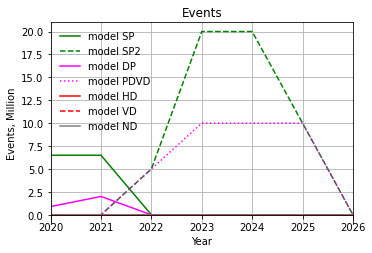

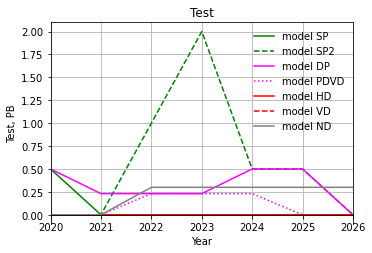

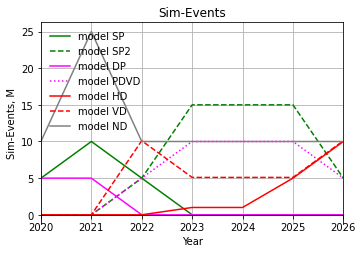

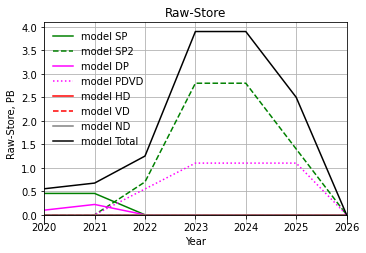

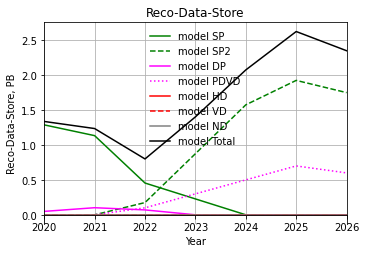

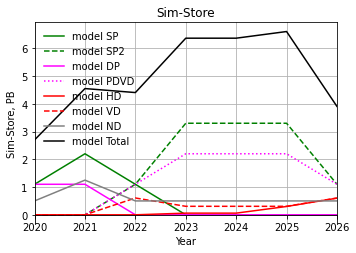

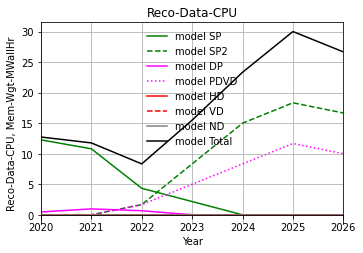

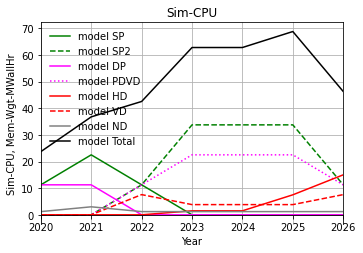

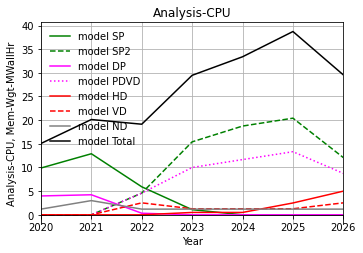

In [10]:
PlotYears = []
for i in range(MinYear,MaxYear+1):
    PlotYears.append(i)
#PlotYears = Years
print ("PlotYears",PlotYears)
# draw things
things = list(Inputs.keys())+["Total"]

if DRAW:
    for stuff in ["Events","Test","Sim-Events","Raw-Store","Reco-Data-Store","Sim-Store","Reco-Data-CPU","Sim-CPU","Analysis-CPU"]:
        DrawDet(shortname,stuff,PlotYears,Data,things,Units,DetColors,DetLines)
    

# if DRAW:
#     DrawDet(shortname,"Events",PlotYears,Data,Inputs.keys(),Units,DetColors,DetLines)
#     DrawDet(shortname,"Reco-Data-CPU",PlotYears,Data,Inputs.keys(),Units,DetColors,DetLines)
#     DrawDet(shortname,"Sim-CPU",PlotYears,Data,Inputs.keys(),Units,DetColors,DetLines)
#     DrawDet(shortname,"Raw-Store",PlotYears,Data,Inputs.keys(),Units,DetColors,DetLines)
#     DrawDet(shortname,"Test",PlotYears,Data,Inputs.keys(),Units,DetColors,DetLines)
#     DrawDet(shortname,"Sim Events",PlotYears,Data,Inputs.keys(),Units,DetColors,DetLines)
#     DrawDet(shortname,"Sim-Store",PlotYears,Data,Inputs.keys(),Units,DetColors,DetLines)
#     DrawDet(shortname,"Reco-Data-CPU",PlotYears,Data,list(Inputs.keys())+["Total"],Units,DetColors,DetLines)
#     DrawDet(shortname,"Sim-CPU",PlotYears,Data,list(Inputs.keys())+["Total"],Units,DetColors,DetLines)
#     DrawDet(shortname,"Raw-Store",PlotYears,Data,list(Inputs.keys())+["Total"],Units,DetColors,DetLines)
  
# for t in Data.keys():
#     print (t)
    
# Captions1 = {"Events":"Million of detector events per year projected",
# "Test":"PB of Test data projected",
# "Sim-Events":"Millions of simulated events per year projected",
# "Raw-Store":"Raw data written per year in PB",
# "Reco-Data-CPU":"CPU needs in core-years for data reconstruction. \
#              Slot weighted wall time takes into account memory use.  Assumes rereconstruction of older data.",
# "Sim-CPU":"CPU needs in core-years for simulation and reconstruction. \
#              Slot weighted wall time takes into account memory use."
# "Reco-Data-Store":
# Sim
# Total-CPU
# Cores
# HS06
# WALL
# Total
# Collab
# FNAL
# CERN

# for key in Data.keys():
#     ToCSV2("Table-"+key,key,PlotYears,Data,Units,Formats)
#     s = TableTex("Table-"+key,key+" values by detector.",key+"\n")ions
#     s2 = DrawTex(shortname,"Total-CPU.png","CPU time in Wall Hours/year. Squares are measured values for 2021.","TotalCPU")

#     print ("tex:",s)
#     texfile.write(s)

In [11]:
# merge far detector info

print ("Data keys",Data.keys())

for dtype in Data.keys():
    print ("Merge protodunes",dtype)
    det = "ProtoDUNEs" 
    Data[dtype][det] = {}
    for year in Years:  
        Data[dtype][det][year] = Data[dtype]["SP"][year] + Data[dtype]["DP"][year] + Data[dtype]["SP2"][year] + Data[dtype]["PDVD"][year]

    Data[dtype].pop("SP")
    Data[dtype].pop("SP2")
    Data[dtype].pop("DP")
    Data[dtype].pop("PDVD")
    


Data keys dict_keys(['Events', 'Test', 'Sim-Events', 'Raw-Store', 'Reco-Data-CPU', 'Sim-CPU', 'Reco-Data-Store', 'Sim-Store', 'Analysis-CPU'])
Merge protodunes Events
Merge protodunes Test
Merge protodunes Sim-Events
Merge protodunes Raw-Store
Merge protodunes Reco-Data-CPU
Merge protodunes Sim-CPU
Merge protodunes Reco-Data-Store
Merge protodunes Sim-Store
Merge protodunes Analysis-CPU


In [12]:
# merge far detector into "FDs
for dtype in Data.keys():
    det = "FDs"
    print ("merge FDS",dtype)
    Data[dtype][det] =  {}
    for year in Years:  
        Data[dtype][det][year] = Data[dtype]["HD"][year] + Data[dtype]["VD"][year]
    Data[dtype].pop("HD")
    Data[dtype].pop("VD")


merge FDS Events
merge FDS Test
merge FDS Sim-Events
merge FDS Raw-Store
merge FDS Reco-Data-CPU
merge FDS Sim-CPU
merge FDS Reco-Data-Store
merge FDS Sim-Store
merge FDS Analysis-CPU


In [13]:
# make a total CPU category

Data["Total-CPU"]={}

for det in CombinedDetectors:
    Data["Total-CPU"][det] =  {}
    for year in Years:
        Data["Total-CPU"][det][year] = Data["Reco-Data-CPU"][det][year] + Data["Sim-CPU"][det][year]
    #print(det,Data["Total-CPU"][det])

In [14]:
# make totals across categories. 

DataTypes = list(Data.keys())

for dt in DataTypes:
    Data[dt]["Total"] = {}
    for year in Years:
        Data[dt]["Total"][year]=0.0
    for k in Data[dt].keys():
        if k == "Total":
          continue  
        for year in Years:
            Data[dt]["Total"][year] += Data[dt][k][year]
    

In [15]:
# and make a special data type for cores

Data["Cores"] = {}
Data["HS06"] = {}
#Data["WALL"] = {}
 
MHrsPerYear = 1000000./365./24.
for k in Data["Total-CPU"].keys():
    if "MARS" not in k :
        efficiency = config["Cores"]["Efficiency"]
    else:
        efficiency = 1

    scaleTo2020 = config["Cores"]["2020Units"]
    Data["Cores"][k]={}
    Data["HS06"][k]={}
#    Data["WALL"][k]={}
    for year in Years:
        Data["Cores"][k][year] = Data["Total-CPU"][k][year]*MHrsPerYear/efficiency/scaleTo2020
        Data["HS06"][k][year] = Data["Total-CPU"][k][year]*MHrsPerYear/efficiency/scaleTo2020*config["kHEPSPEC06PerCPU"]
#        Data["WALL"][k][year] = Data["Total-CPU"][k][year]*MHrsPerYear/efficiency/scaleTo2020


In [16]:
#  for Storage work out split between different institutions

Splits = {}
for f in SplitsEarly:
    Splits[f] = {}
    for t in SplitsEarly[f]:
        Splits[f][t] = {}
        for loc in SplitsEarly[f][t]: 
            Splits[f][t][loc] = {}
            #print (f,t,Splits[f][t],Splits[f][t][0])
    
            for y in Years:
                if y < SplitsYear:
                    Splits[f][t][loc][y]=SplitsEarly[f][t][loc]
                else:
                    Splits[f][t][loc][y]=SplitsLater[f][t][loc]

In [17]:
# now do some Cumulative-work.  Stuff stays on tape/disk for different amounts of time and we have multiple copies

Storage = {}
for k in StorageTypes:
    Storage[k] = {}
Storage["Total"] = {}
Storage["National"] = {}
Storage["FNAL"] = {}
Storage["CERN"] = {}
Storage["Total"]["Cumulative-Tape"] = {}
Storage["Total"]["Cumulative-Disk"] = {}
Storage["FNAL"]["Cumulative-Tape"] = {}
Storage["FNAL"]["Cumulative-Disk"] = {}
Storage["CERN"]["Cumulative-Tape"] = {}
Storage["CERN"]["Cumulative-Disk"] = {}
Storage["Collab"]["Cumulative-Tape"] = {}
Storage["Collab"]["Cumulative-Disk"] = {}


for year in Years:
    Storage["Total"]["Cumulative-Tape"][year] = 0.0
    Storage["Total"]["Cumulative-Disk"][year] = 0.0

for k in StorageTypes:
    Storage[k]["Tape"] = {}
    Storage[k]["Disk"] = {}
    for year in Years:
        Storage[k]["Tape"][year] = Data[k]["Total"][year]*TapeCopies[k]
        Storage[k]["Disk"][year] = Data[k]["Total"][year]*DiskCopies[k]
    Storage[k]["Cumulative-Tape"] = cumulateMap(Years,Storage[k]["Tape"],TapeLifetimes[k])
    Storage[k]["Cumulative-Disk"] = cumulateMap(Years,Storage[k]["Disk"],DiskLifetimes[k])
    
    for year in Years:
        Storage["Total"]["Cumulative-Tape"][year] += Storage[k]["Cumulative-Tape"][year]
        Storage["Total"]["Cumulative-Disk"][year] += Storage[k]["Cumulative-Disk"][year]
        
for loc in Splits["Disk"]["Raw-Store"]:
    for year in Years:
        Storage[loc]["Cumulative-Disk"][year] = 0.0
        Storage[loc]["Cumulative-Tape"][year] = 0.0       
        for k in StorageTypes:
              Storage[loc]["Cumulative-Disk"][year] += Storage[k]["Cumulative-Disk"][year]*Splits["Disk"][k][loc][year]
              Storage[loc]["Cumulative-Tape"][year] += Storage[k]["Cumulative-Tape"][year]*Splits["Tape"][k][loc][year]


# cdisk = SumOver1("Cumulative-Disk",Data)
# print ("sum over",cdisk)

# for year in Years:
#         Data[loc]["Cumulative-Disk"][year] = 0.0
#         Data[loc]["Cumulative-Tape"][year] = 0.0       
#         for k in StorageTypes:
#               Data[loc]["Cumulative-Disk"][year] += Data[k]["Cumulative-Disk"][year] 
#               Data[loc]["Cumulative-Tape"][year] += Data[k]["Cumulative-Tape"][year] 


KeyError: 'Collab'

In [ ]:

texfile.write("\\section{Projected Disk and Tape needs by source and site}\n")
#ToCSV1(shortname+"-Disk_by_location","Cumulative-Disk",PlotYears,Storage,Units,Formats)
#ToCSV1(shortname+"-Tape_by_location","Cumulative-Tape",PlotYears,Storage,Units,Formats)
# s = "\\begin{table}[h]\n \\centering\\csvautotabularright\
# {external/DUNERSEUSAGE-2022-11-14.csv}\n \\label{Cumulative-Tape}\n\
# \\caption{Rucio report on storage usage 2022-11-14 from the Scotgrid Dashboard \
# \\href{https://dune.monitoring.edi.scotgrid.ac.uk/app/dashboards}{https://dune.monitoring.edi.scotgrid.ac.uk/app/dashboards}.}\n \\end{table}\n"
# s.replace("_","\_")
# texfile.write(s)

# s = TableTex(shortname+"-Disk_by_location","Disk requests by location. The top 4 lines show the source, the bottom 4 show the locations requested and the total request.","Cumulative-Disk"+"\n")
# texfile.write(s)
# s = TableTex(shortname+"-Tape_by_location","Tape requests by location. The top 4 lines show the source, the bottom 4 show the locations requested and the total request.","Cumulative-Tape"+"\n")
# texfile.write(s)

# texfile.write("\\clearpage\n")


In [ ]:
# now do some plots

Types = ["ProtoDUNEs","FDs","ND", "Analysis","Total"]

cpuactual = []
coreactual = []
wallactual = []



DrawDet(shortname,"Total-CPU",PlotYears,Data,Types,Units,DetColors,DetLines,cpuactual)
DrawDet(shortname,"Cores",PlotYears,Data,Types,Units,DetColors,DetLines,coreactual)
#DrawDet(shortname,"WALL",PlotYears,Data,Types,Units,DetColors,DetLines,wallactual)
DrawDet(shortname,"HS06",PlotYears,Data,Types,Units,DetColors,DetLines,wallactual)

for x in ["Total-CPU","Cores","HS06"]:
    ToCSV2(shortname+x,x,PlotYears,Data,Units,Formats)

In [ ]:

    
Captions2 = {"Events":"Projected million of detector events per year.  Reconstructed data resources are based on this number.",
"Test":"Projected PB of Test data per year.",
"Sim-Events":"Projected millions of simulated events per year. Simulated data resources are based on this number. ",
"Raw-Store":"Projected raw data written per year in PB, derived from the number of events.",
"Reco-Data-CPU":"Projected CPU needs in core-years for data reconstruction. \
             Slot weighted wall time takes into account memory use and an efficiency correction.  Assumes rereconstruction of several years of older data.",
"Sim-CPU":"Projected CPU needs in core-years for simulation and reconstruction. \
             Slot weighted wall time takes into account memory use and an efficiency correction. Based directly on the number of simulated Events.",
"Reco-Data-Store":"Projected PB of reconstructed data per year. Includes reprocessing.",
"Sim-Store":"Projected PB of simulated data/year",
"Total-CPU":"Slot weighted CPU needs in core-years. Slot weighted wall time takes into account memory and efficiency.",
"Cores":"Slot weighted CPU needs in number of cores. Slot weighted wall time takes into account memory and efficiency.",
"HS06":"Slot weighted CPU needs in kHS06 hrs. Slot weighted wall time takes into account memory and efficiency.",
"Analysis-CPU":"Slot weighted analysis CPU needs in core-years. Assumed to be a weighted fraction of reco+sim needs.",
            }
print (Data["Events"]["ProtoDUNEs"])
print (Data["Events"]["FDs"])
print (Data["Events"]["ND"])

    

In [ ]:


# for key in ["Cores","Total-CPU","HS06"]:
#     print ("Got to Here")
#     if not key in Units:
#         print ("no units for key",key)
#         continue
#     ToCSV2(shortname+"-"+key,key,PlotYears,Data,Units,Formats)
#     s = TableTex(shortname+"-"+key,Captions2[key],key+"\n")
#     #DrawDet(shortname,key,PlotYears,Data,list(Data[key].keys()),Units,DetColors,DetLines)
#     #s2 = DrawTex(shortname,key+".png",Captions2[key],key)
#     print  ("Got to here")
#     s2 = BothTex(shortname,key+".png",Captions2[key],key)
#     #texfile.write(s2)
#     tablefile.write(s2)

In [ ]:
print (Storage.keys())
    
Captions1 = {"Cumulative-Tape":"Cumulative Tape needs in PB. Includes data lifetimes", 
             "Cumulative-Disk":"Cumulative Disk needs in PB. Includes data lifetimes"}
            

for key in ['Cumulative-Tape', 'Cumulative-Disk']:
    if not key in Units:
        print ("no units for key",key)
        continue
    actual = None
    if key == "Cumulative-Tape":
        actual = tapeactual
    if key == "Cumulative-Disk":
        actual = diskactual
    print (actual)
    ToCSV1(shortname+"-"+key,key,PlotYears,Storage,Units,Formats)
    s = TableTex(shortname+"-"+key,Captions1[key],key+"\n")
    print (key,s)
    DrawType(shortname,key,PlotYears,Storage,StorageTypes+["Total"],Units,TypeColors,TypeLines)
    s2 = BothTex(shortname,key+".png",Captions1[key],key)

    #texfile.write(s2)
    texfile.write(s2)

In [ ]:
for key in Data.keys():
    if not key in Units:
        print ("no units for key",key)
        continue
    ToCSV2(shortname+"-"+key,key,PlotYears,Data,Units,Formats)
    s = TableTex(shortname+"-"+key,Captions2[key],key+"\n")
    #DrawDet(shortname,key,PlotYears,Data,list(Data[key].keys()),Units,DetColors,DetLines)
    #s2 = DrawTex(shortname,key+".png",Captions2[key],key)
    s2 = BothTex(shortname,key+".png",Captions2[key],key)
    #texfile.write(s2)
    tablefile.write(s2)

In [ ]:

tapepoints = np.zeros(len(Years))
diskpoints = np.zeros(len(Years))

#DrawType(shortname,"Tape",Years,Data,StorageTypes+["Total"],Units,TypeColors,TypeLines,None,None)
#DrawType(shortname,"Cumulative-Tape",PlotYears,Storage,StorageTypes+["Total"],Units,TypeColors,TypeLines,None,None)
#DrawType(shortname,"Cumulative-Disk",PlotYears,Storage,StorageTypes+["Total"],Units,TypeColors,TypeLines,None,None)
#DrawType(shortname,"Cumulative-Disk",Years,Data,StorageTypes+["Total"],Units,TypeColors,TypeLines,None,None)



In [ ]:
tablefile.close()
#texfile.write("\\input{bibmaker.tex}\n")
#texfile.write("\\clearpage\n")
#texfile.write("\\section{Appendix - Model inputs}\n")
#texfile.write("\\input{"+dirname+"/tables.tex}\n")
#texfile.write("\\end{document}\n")
texfile.close()

In [ ]:
cmd='pdflatex CCB-Report-2022'
get_ipython().system('{cmd}')